In [1]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

2023-06-03 10:10:29.566548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 10:10:30.765173: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-03 10:10:34.854765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-03 10:10:34.855035: W tensorflow/strea

tf.Tensor(-116.74903, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# <font color=maroon>Model Building (Baseline) - Inception-V3

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 256
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model

In [4]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [5]:
pre_model.trainable = False

In [6]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Baseline')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "InceptionV3_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 26,220,042
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/20


2023-06-03 10:11:19.957975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-03 10:11:21.850889: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 10:11:21.852690: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 10:11:21.852749: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-03 10:11:21.853713: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 10:11:21.853859: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


196/196 [==============================] - 50s 190ms/step - loss: 6.6332 - accuracy: 0.7299 - val_loss: 0.5091 - val_accuracy: 0.8314
Epoch 2/20
196/196 [==============================] - 38s 194ms/step - loss: 0.3823 - accuracy: 0.8701 - val_loss: 0.5025 - val_accuracy: 0.8408
Epoch 3/20
196/196 [==============================] - 34s 174ms/step - loss: 0.2887 - accuracy: 0.9020 - val_loss: 0.5662 - val_accuracy: 0.8276
Epoch 4/20
196/196 [==============================] - 39s 197ms/step - loss: 0.2354 - accuracy: 0.9186 - val_loss: 0.5964 - val_accuracy: 0.8297
Epoch 5/20
196/196 [==============================] - 35s 177ms/step - loss: 0.1938 - accuracy: 0.9322 - val_loss: 0.6553 - val_accuracy: 0.8233
Epoch 6/20
196/196 [==============================] - 39s 200ms/step - loss: 0.1495 - accuracy: 0.9469 - val_loss: 0.7207 - val_accuracy: 0.8180
Epoch 8/20
196/196 [==============================] - 34s 173ms/step - loss: 0.1404 - accuracy: 0.9497 - val_loss: 0.7080 - val_accuracy: 0.8

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

40/40 [==============================] - 6s 142ms/step - loss: 0.9677 - accuracy: 0.8420
Test loss:  0.9676980376243591
Test accuracy: 0.8420000076293945


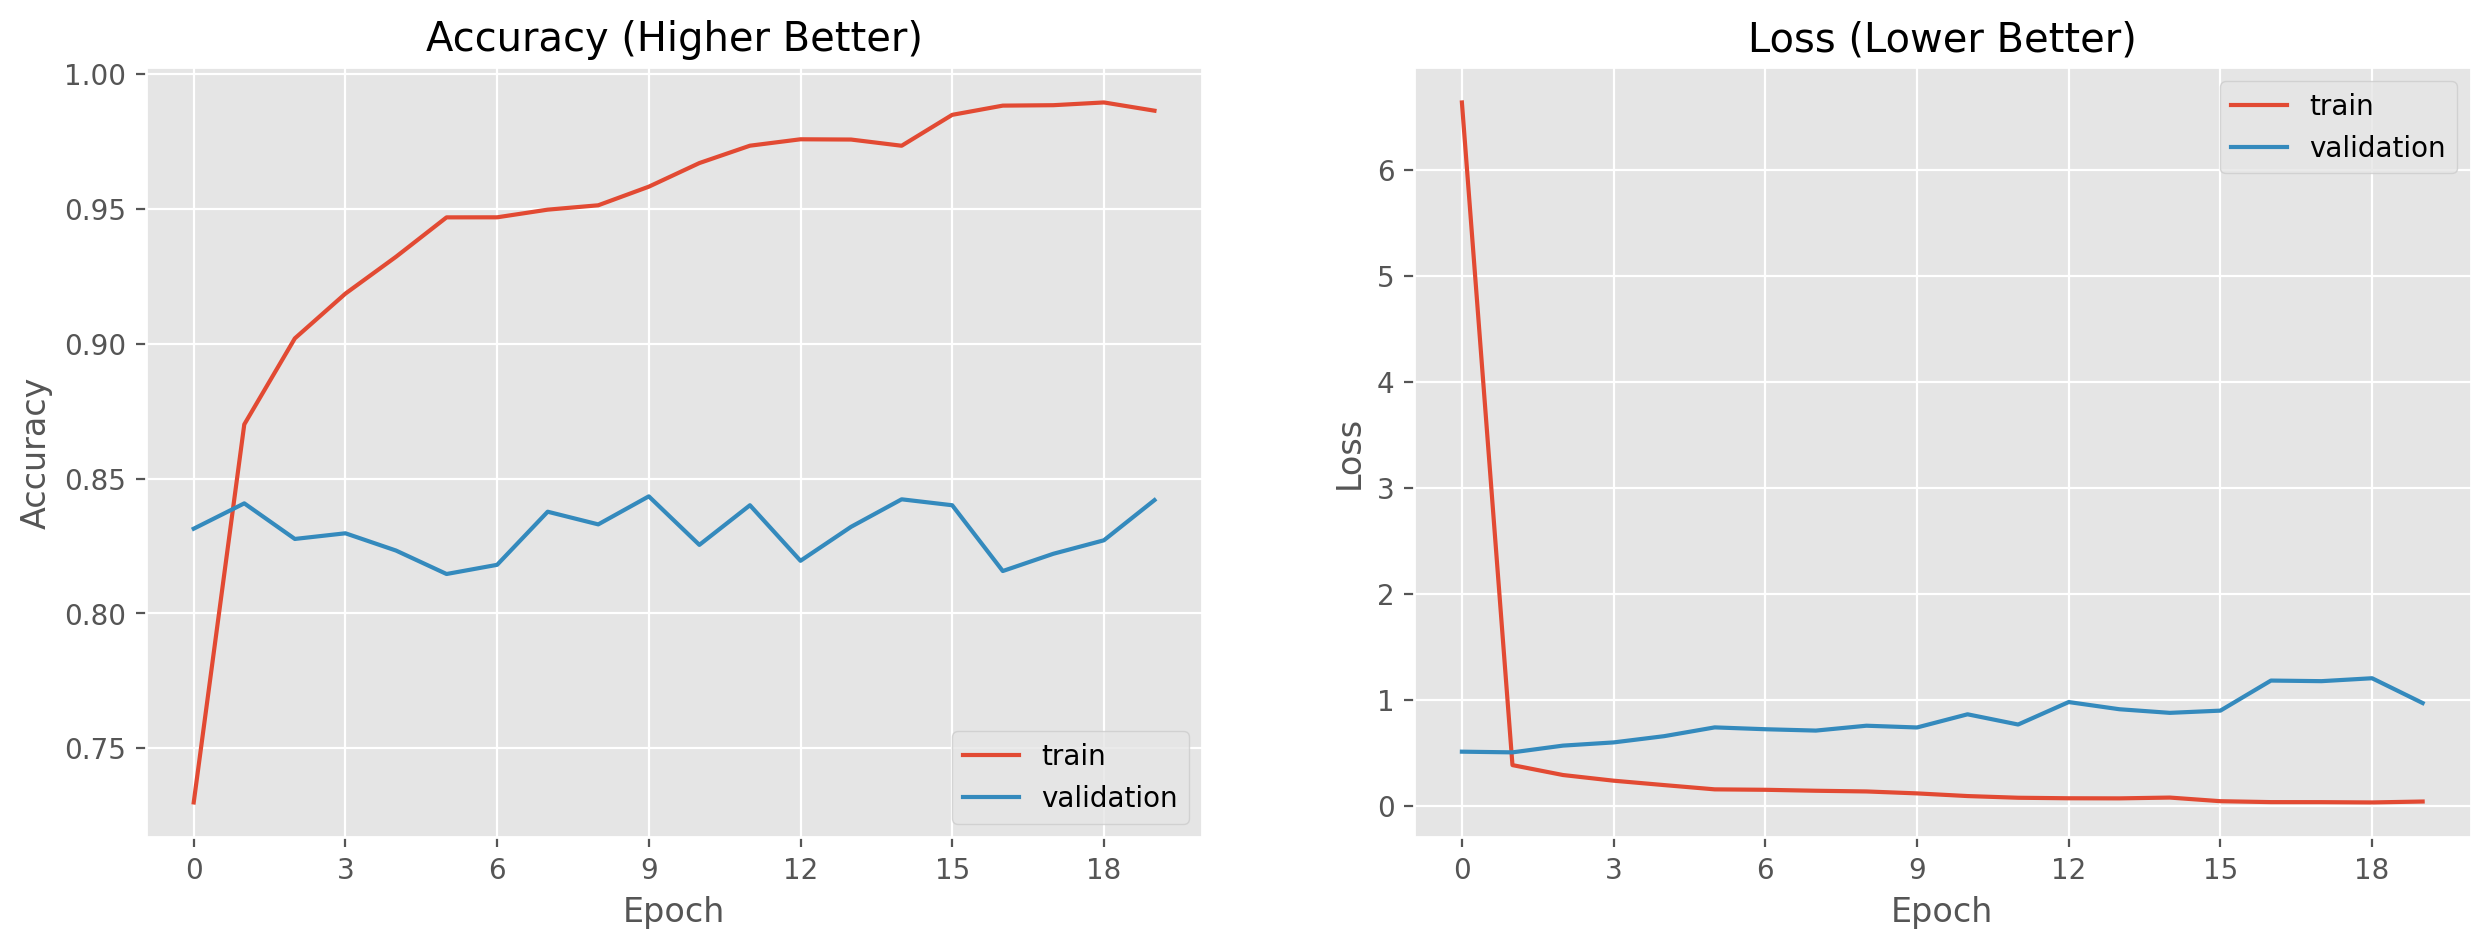

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

40/40 [==============================] - 7s 139ms/step
[5 8 8 ... 5 1 7]


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [11]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


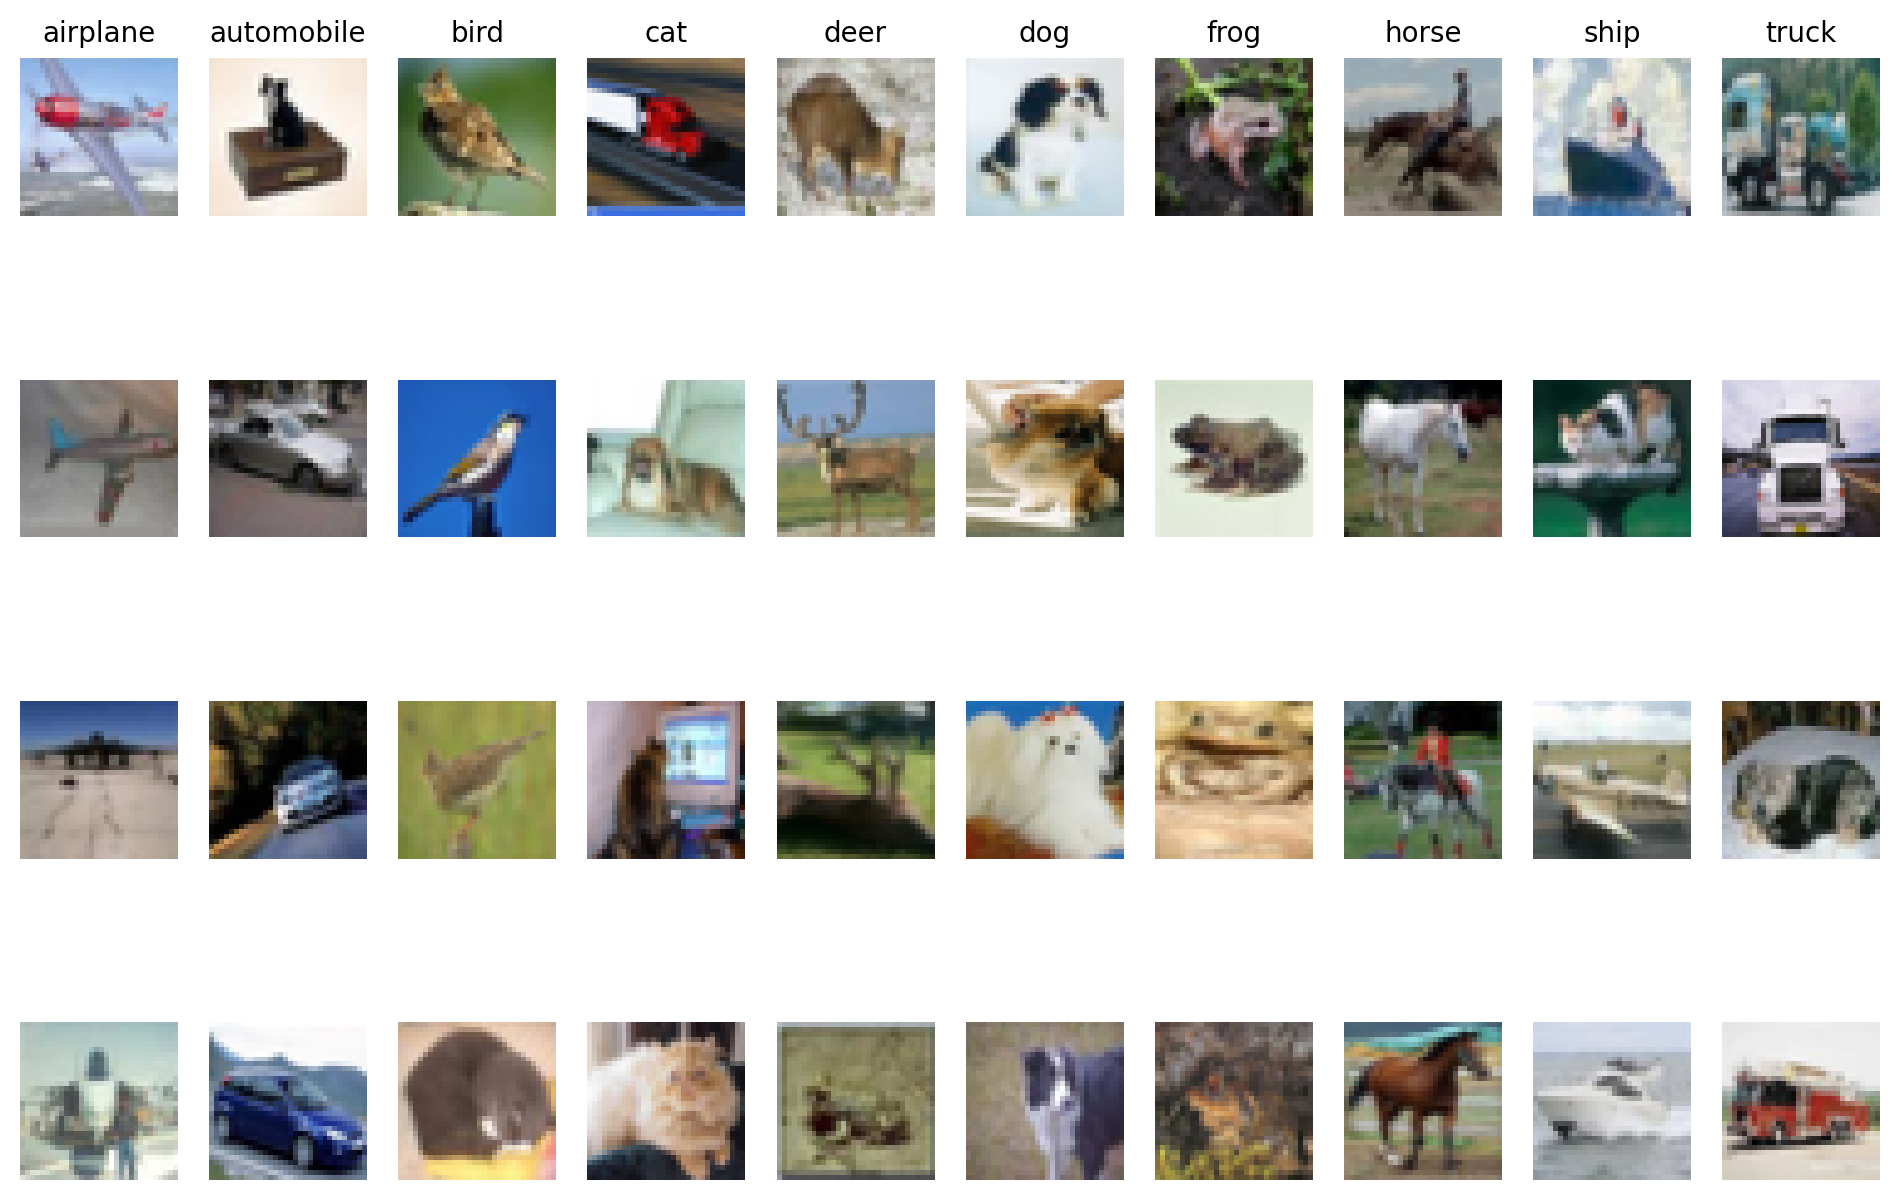

In [13]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Visualising confusion matrix

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [15]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [16]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.842


In [17]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.8431908275169168
Recall: 0.842
F1 Score: 0.8405659054851041


### Creating confusion matrix

In [18]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

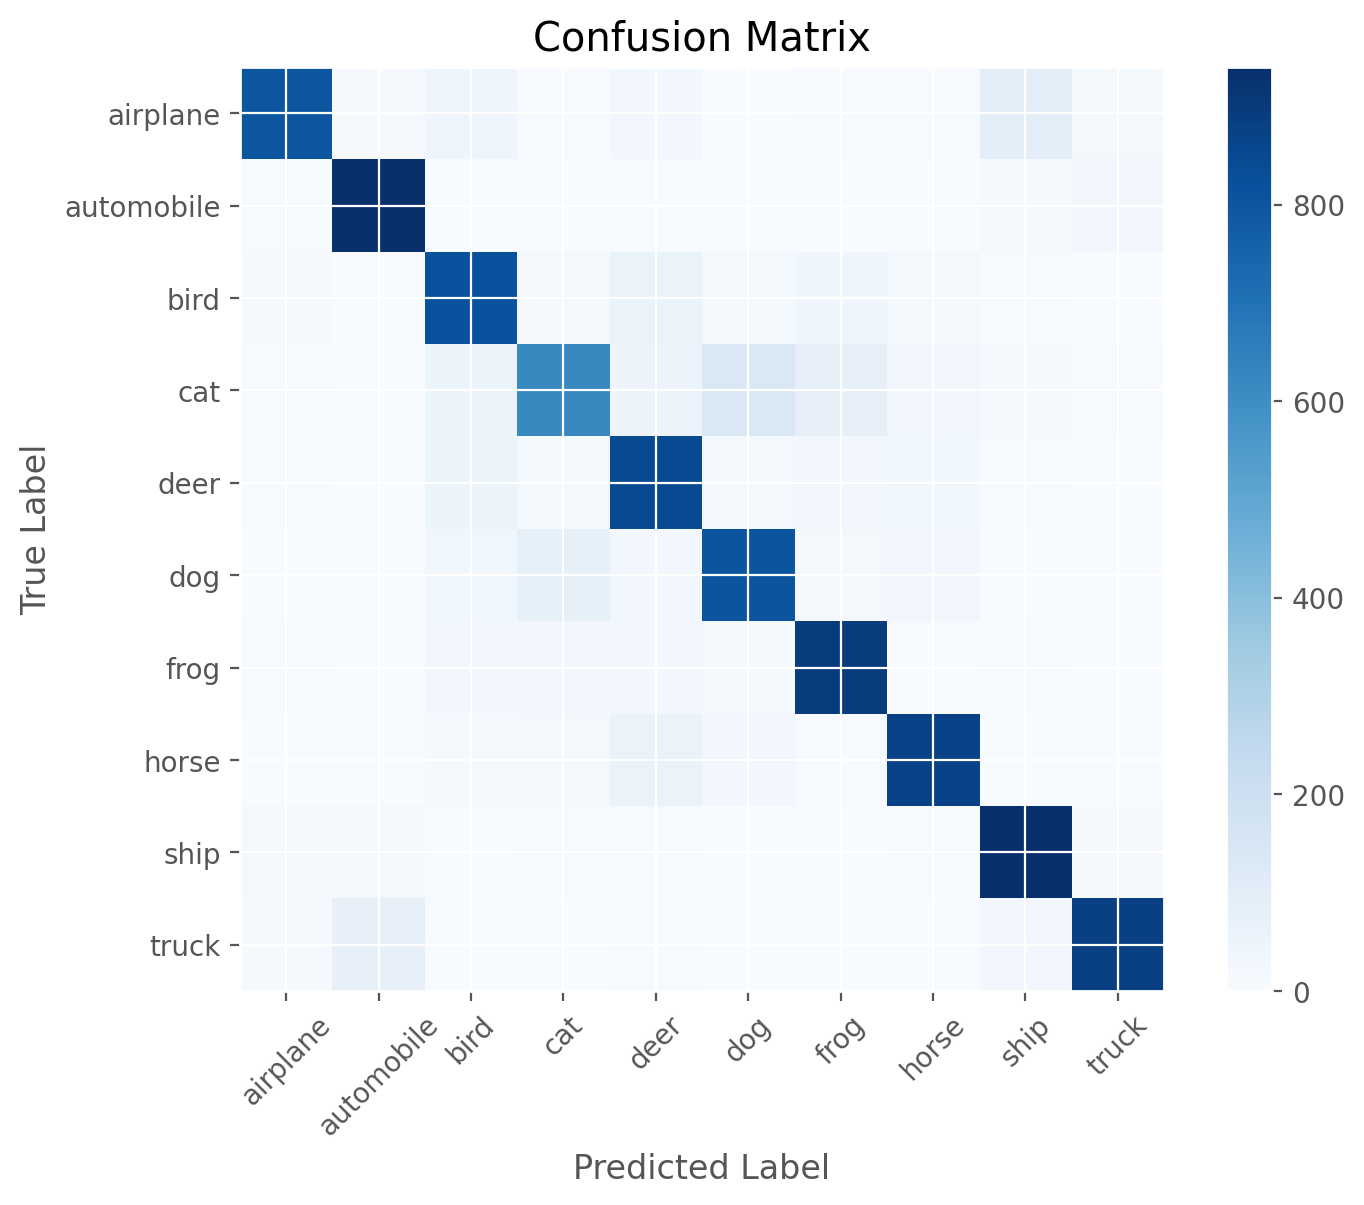

In [19]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [20]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.92      0.80      0.86      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.78      0.82      0.80      1000
         cat       0.78      0.62      0.69      1000
        deer       0.76      0.84      0.80      1000
         dog       0.79      0.81      0.80      1000
        frog       0.83      0.89      0.86      1000
       horse       0.87      0.88      0.87      1000
        ship       0.86      0.94      0.90      1000
       truck       0.93      0.88      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# <font color=maroon>Model Building Tuned 1 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 64
- Increased epoch to 50
- Added early stop

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
pre_model.trainable = False

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_1')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'))

Model: "InceptionV3_Tuned_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,917,290
Trainable params: 67,114,506
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 266s 323ms/step - loss: 2.1922 - accuracy: 0.7801 - val_loss: 0.6856 - val_accuracy: 0.7760
Epoch 2/50
7

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 36s 228ms/step - loss: 0.7316 - accuracy: 0.8316
Test loss:  0.7315564155578613
Test accuracy: 0.83160001039505


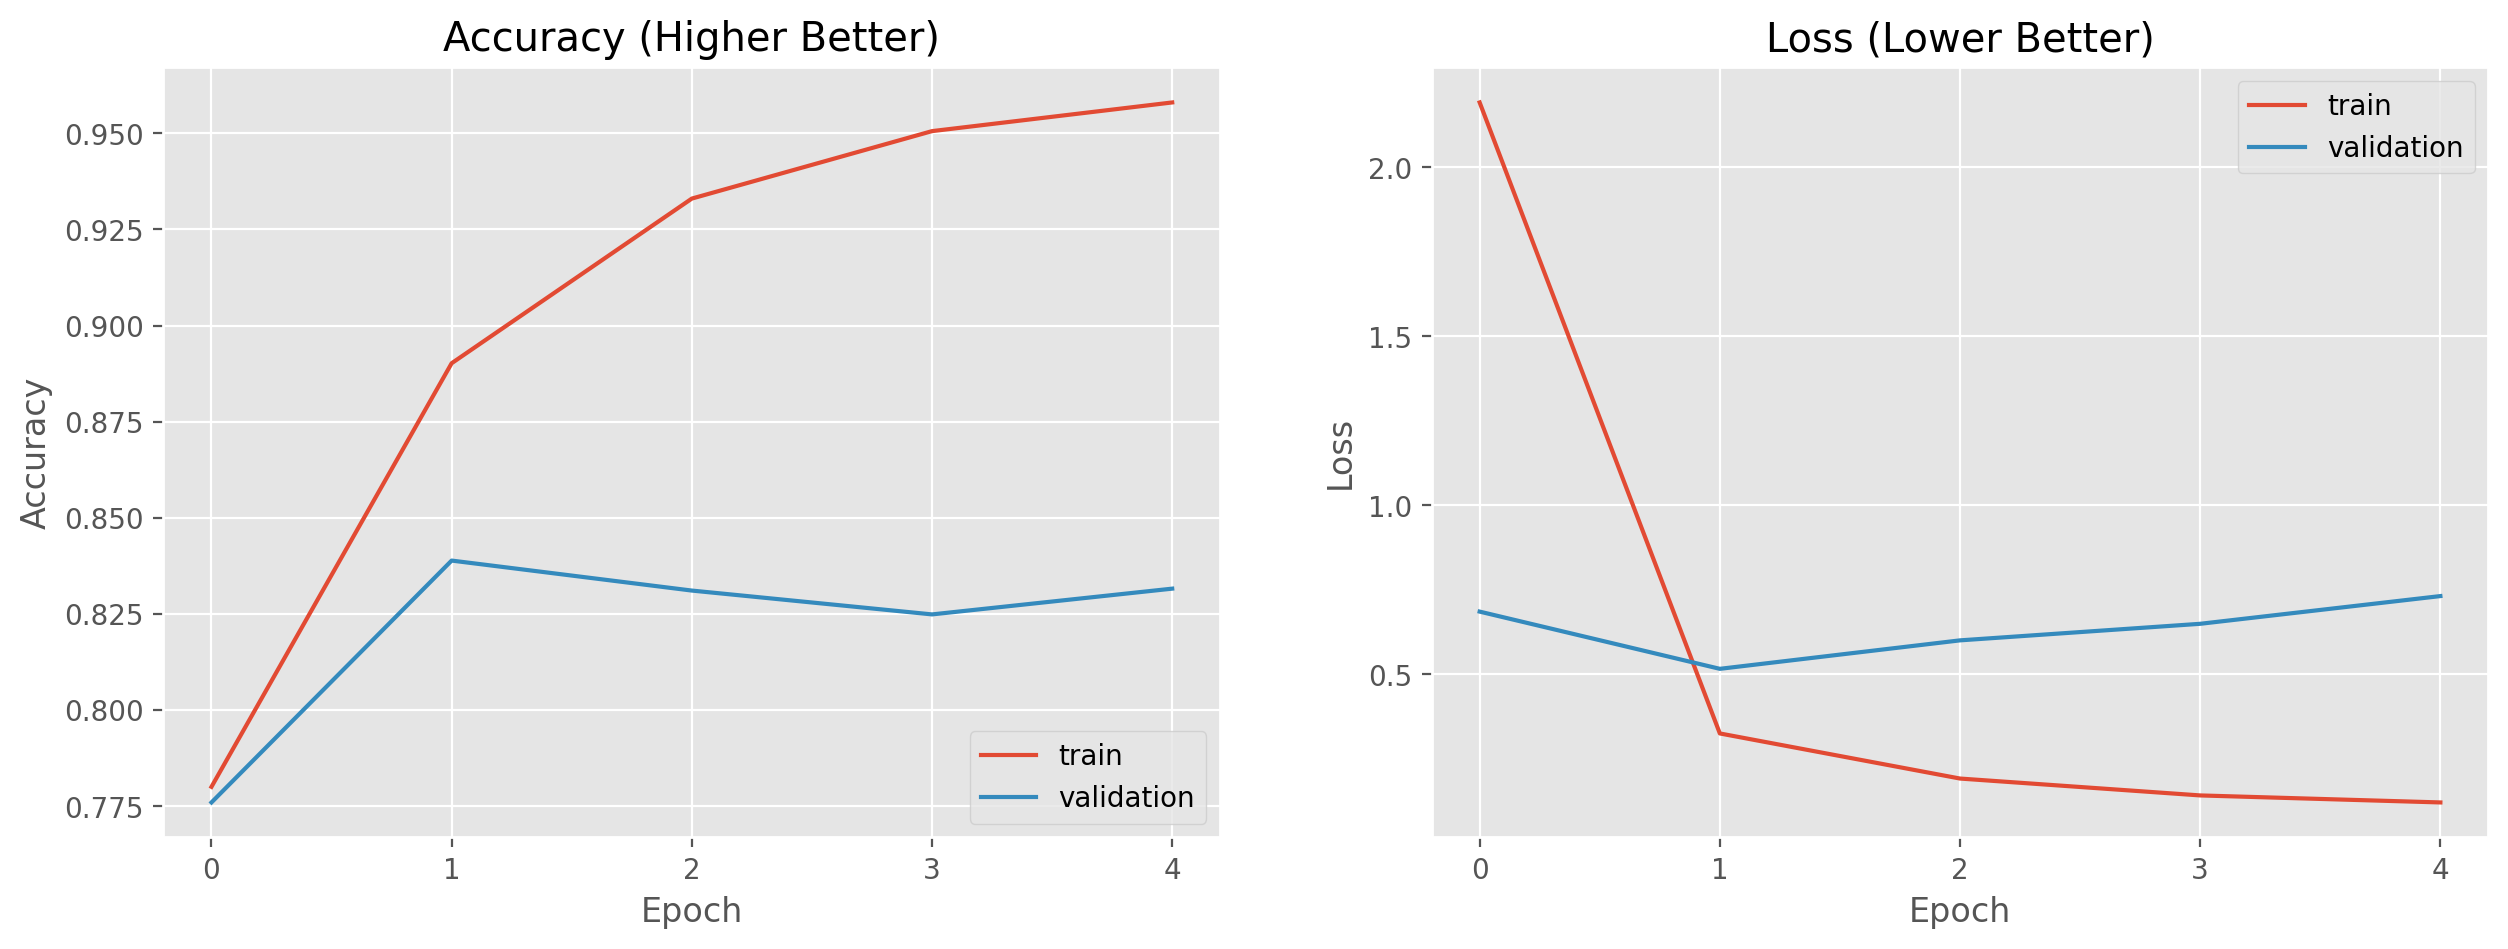

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 37s 224ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


C:\Users\mctro\AppData\Local\Temp\ipykernel_14716\2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


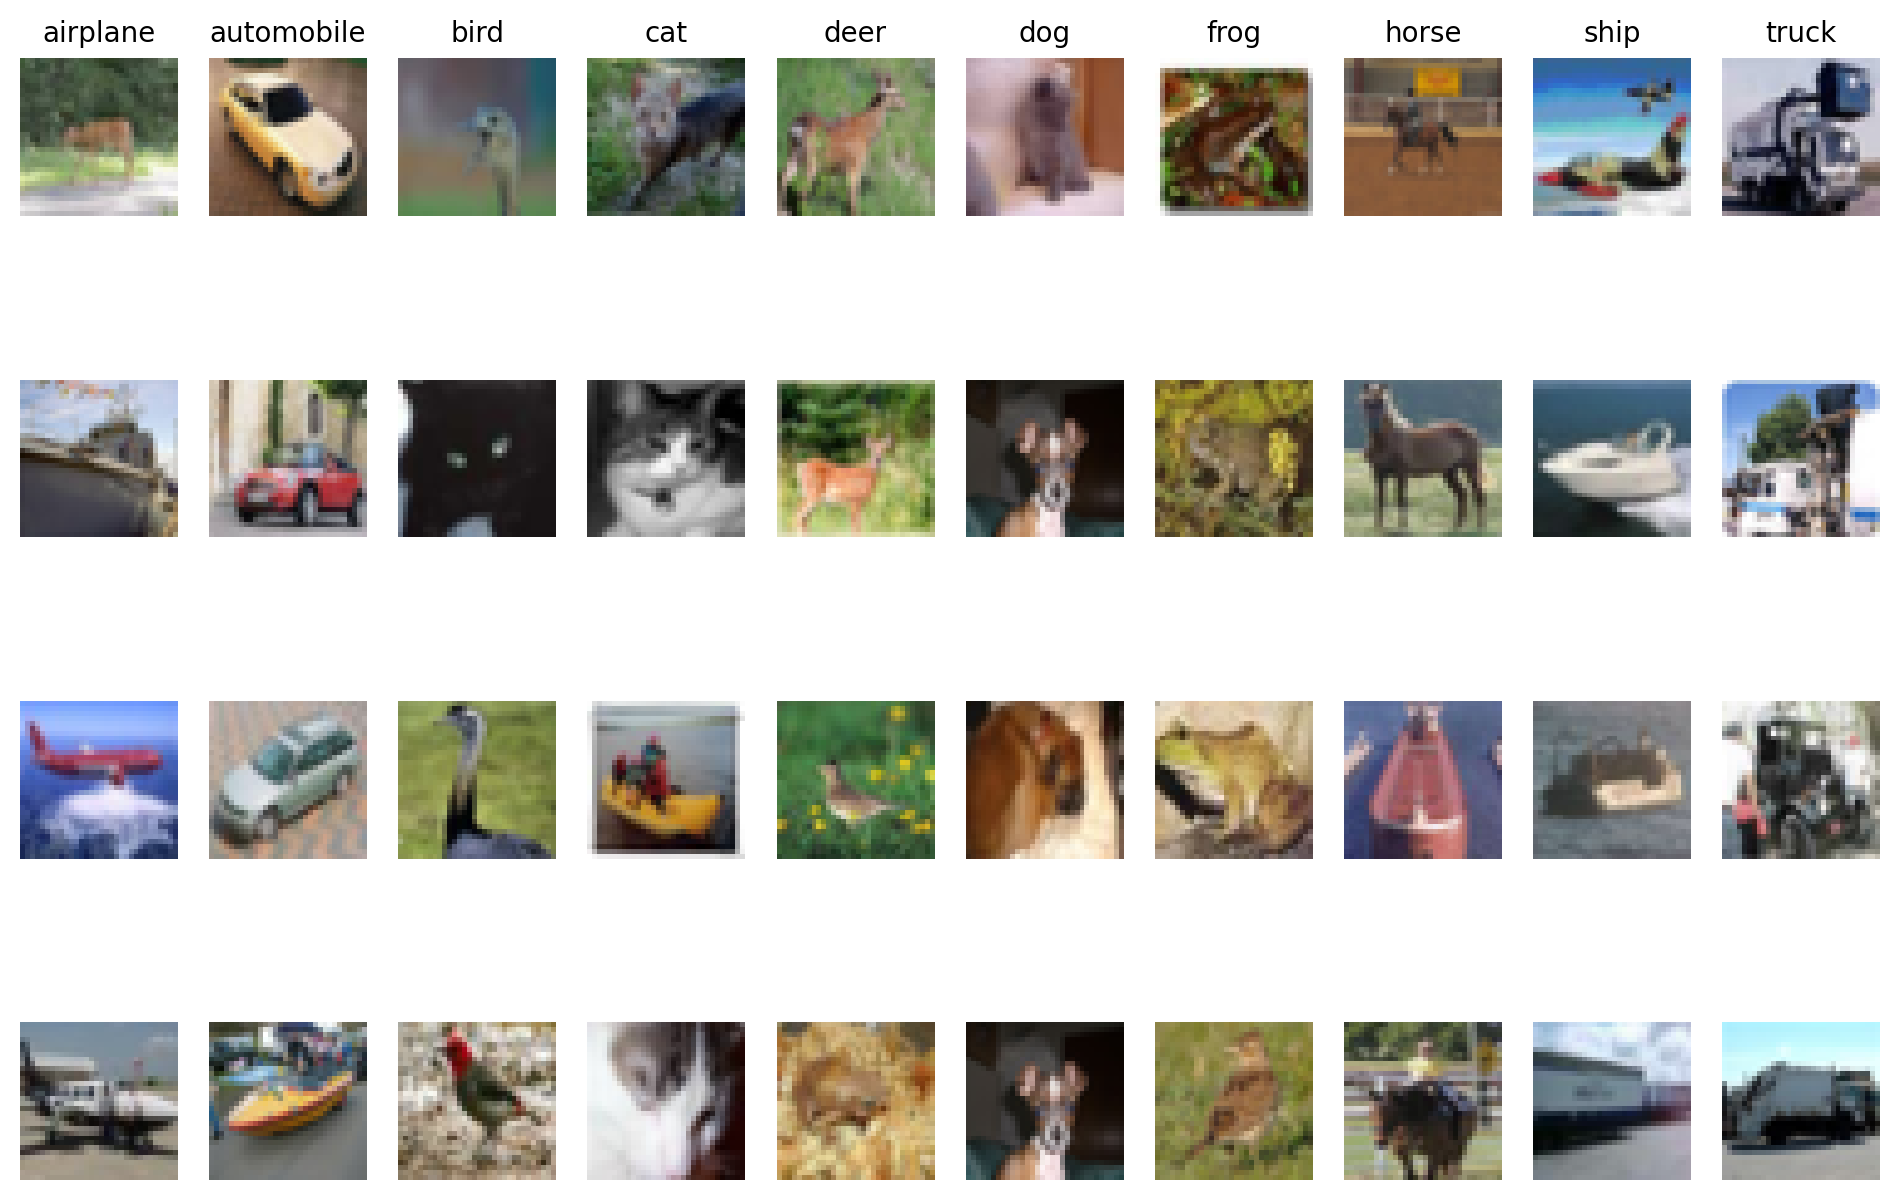

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Visualising confusion matrix

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [27]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9578


In [28]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9585418938381332
Recall: 0.9578
F1 Score: 0.9576089896529669


### Creating confusion matrix

In [29]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

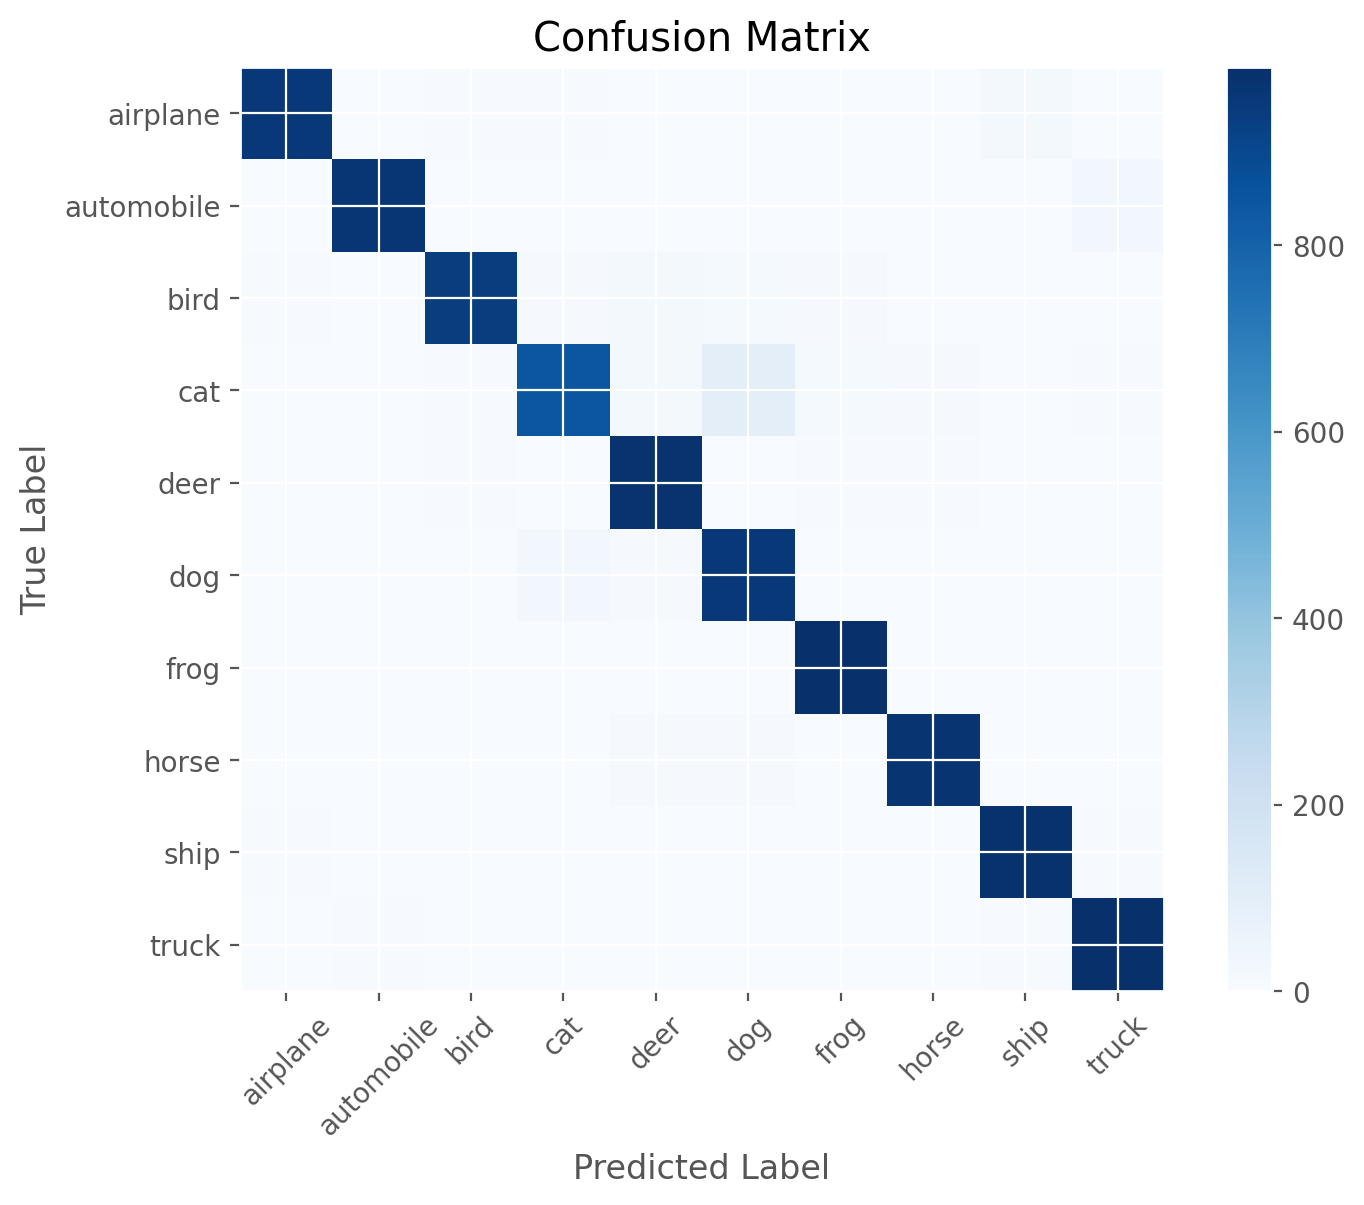

In [30]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.98      0.96      0.97      1000
  automobile       0.99      0.97      0.98      1000
        bird       0.98      0.94      0.96      1000
         cat       0.95      0.85      0.89      1000
        deer       0.94      0.98      0.96      1000
         dog       0.88      0.96      0.92      1000
        frog       0.97      0.99      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.97      0.98      0.97      1000
       truck       0.96      0.98      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# <font color=maroon>Model Building Tuned 2 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 32
- Increased epoch to 50
- Added early stop
- Set trainable = True

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
pre_model.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_2')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'))

Model: "InceptionV3_Tuned_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,917,290
Trainable params: 88,882,858
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
1563/1563 [==============================] - 769s 456ms/step - loss: 1.6952 - accuracy: 0.4539 - val_loss: 1.0988 - val_accuracy: 0.6194
Epoch 2/20
156

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 37s 116ms/step - loss: 0.5111 - accuracy: 0.8511
Test loss:  0.5110715627670288
Test accuracy: 0.8511000275611877


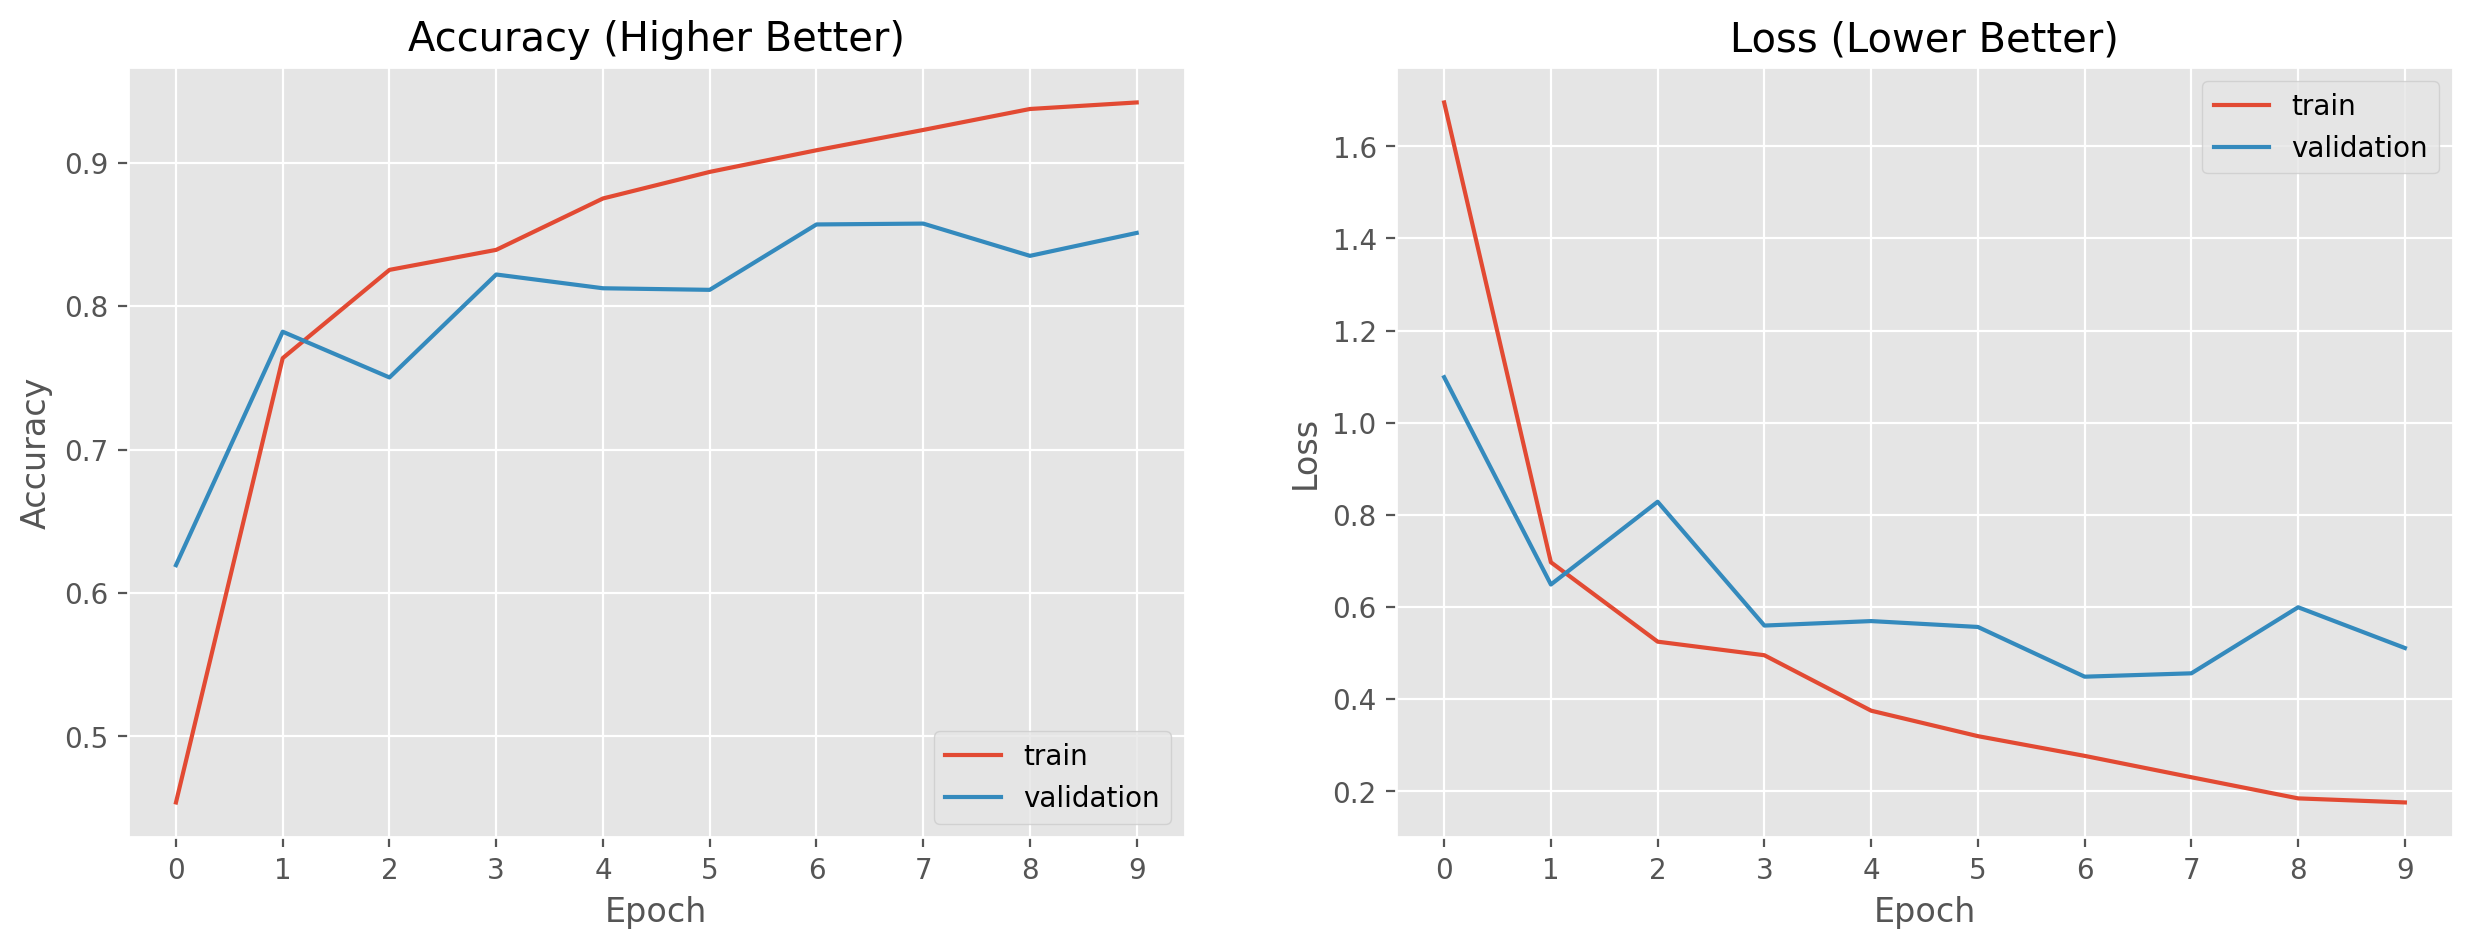

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 37s 114ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


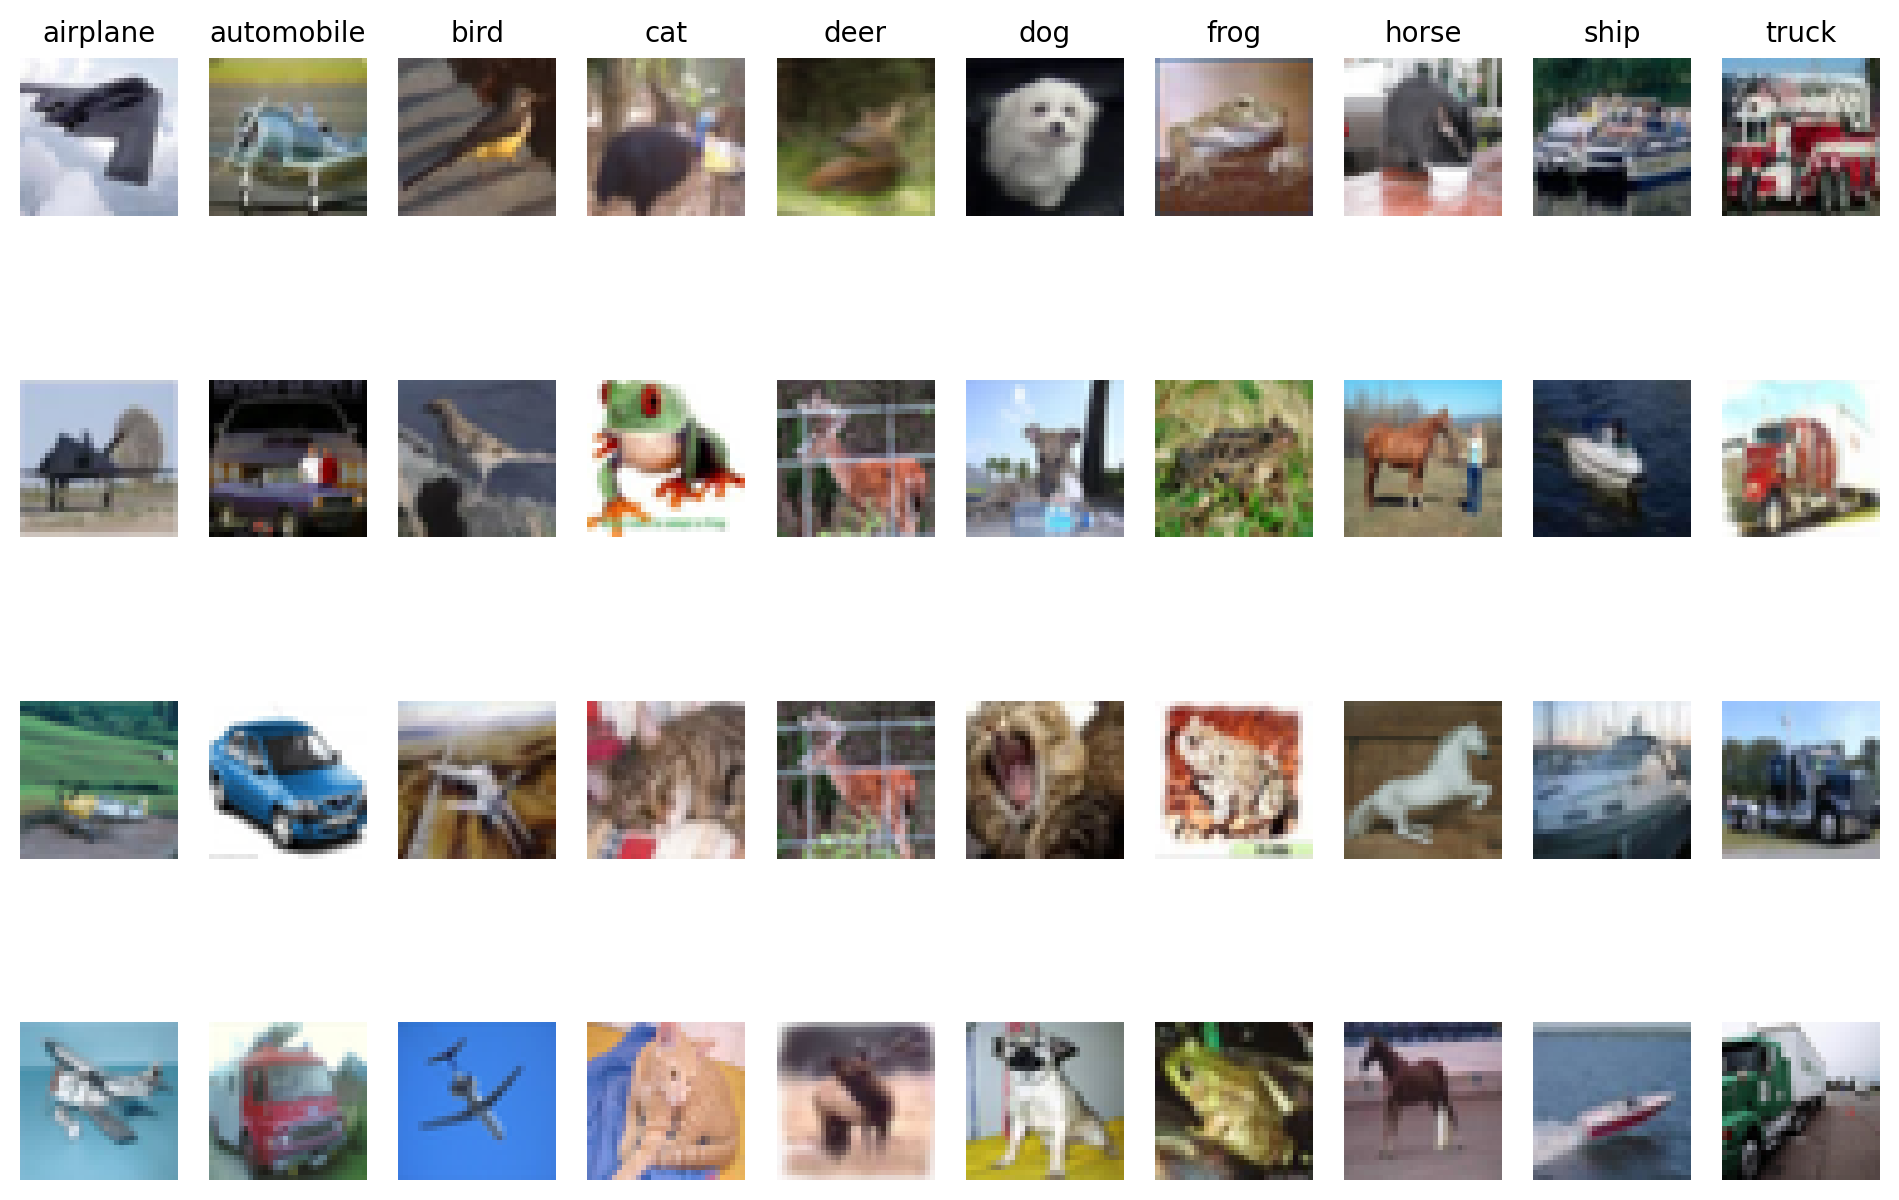

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 3 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 224
- Changed batch size to 32
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

In [ ]:
pre_model.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_3')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop])

Model: "InceptionV3_Tuned_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 47,988,394
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/50
1563/1563 [==============================] - 456s 255ms/step - loss: 1.3176 - accuracy: 0.5445 - val_loss: 0.8798 - val_accuracy: 0.7177
Epoch 2/50
156

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 22s 70ms/step - loss: 0.4139 - accuracy: 0.8976
Test loss:  0.41385436058044434
Test accuracy: 0.897599995136261


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 22s 65ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


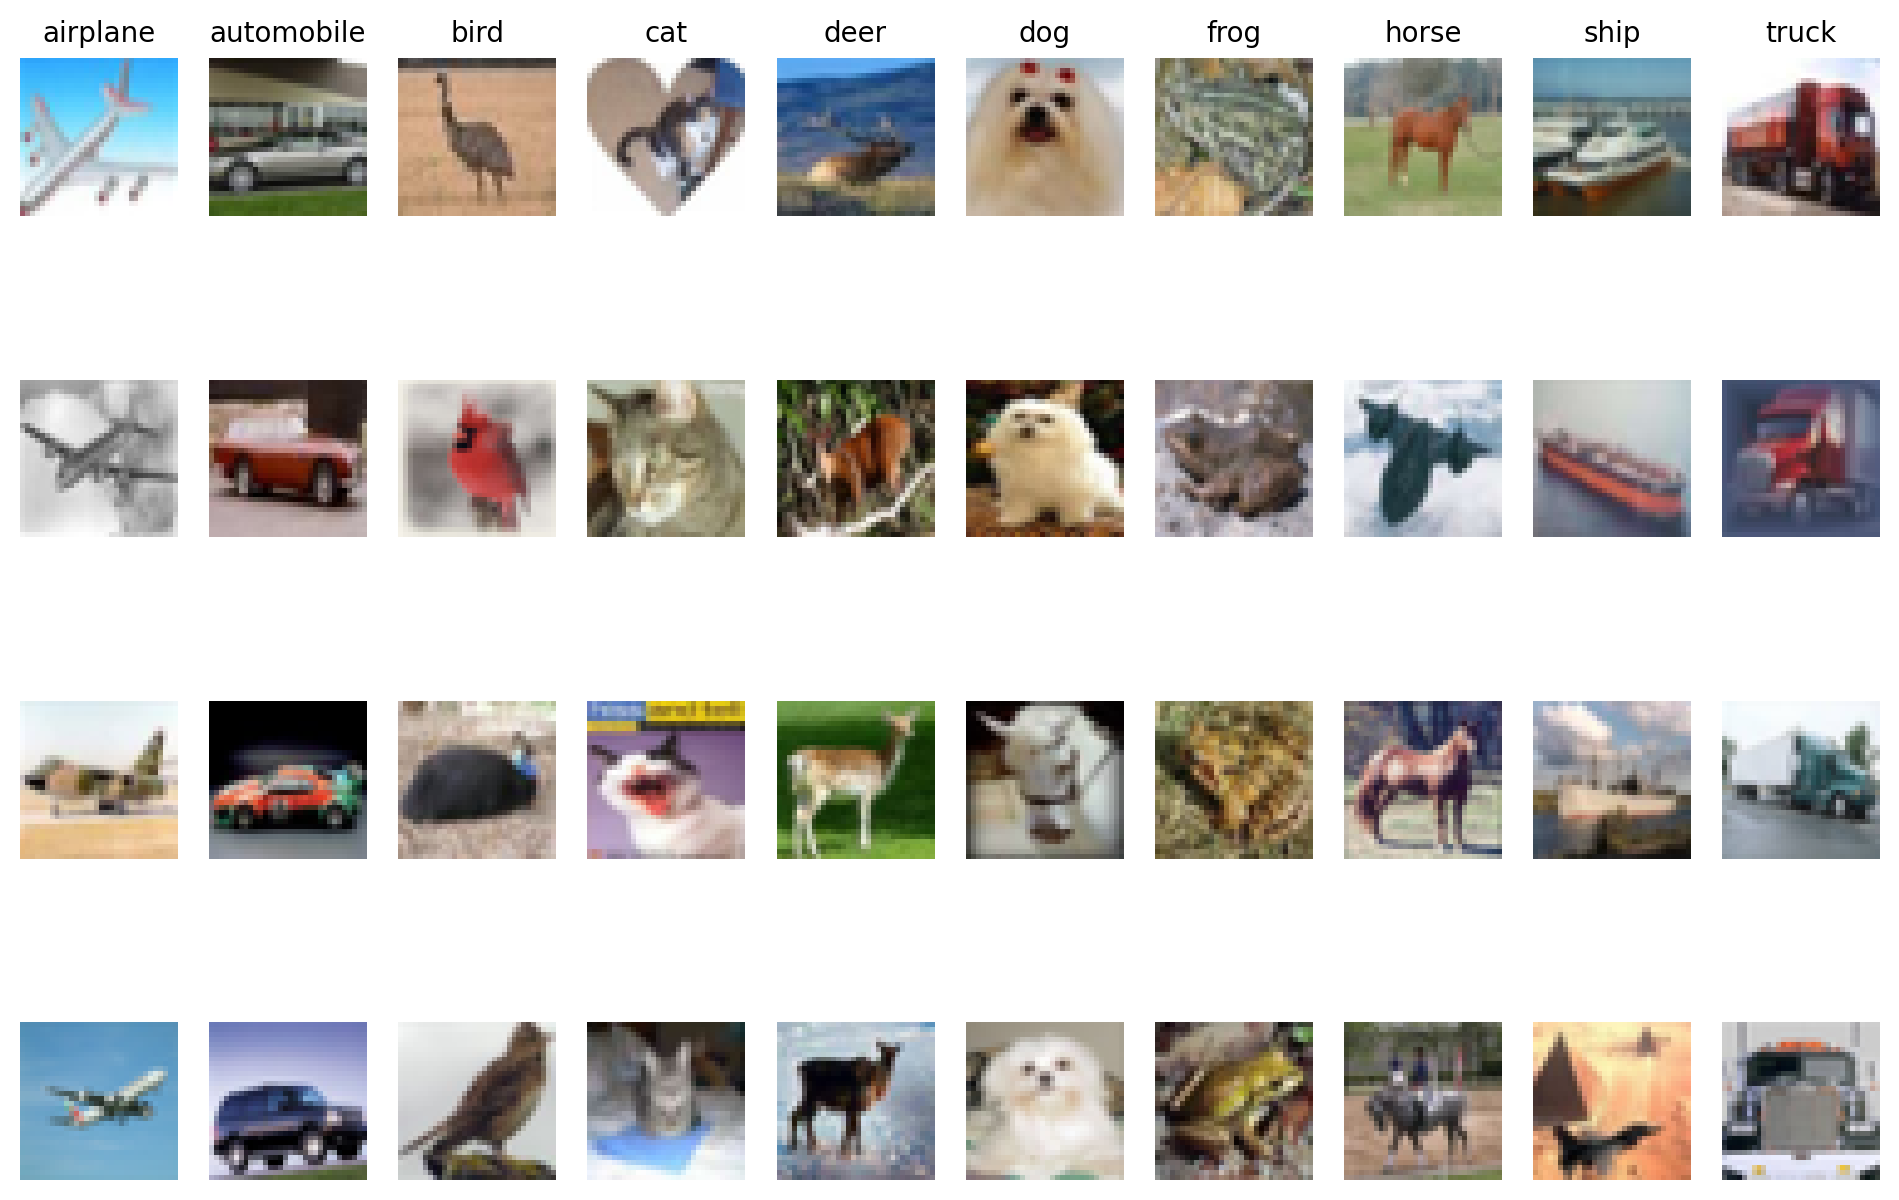

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 4 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 224
- Changed batch size to 128
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing
- Added layers into fully conencted layers

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_model.layers:
  layer.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_4')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop])

Model: "InceptionV3_Tuned_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 48,414,250
Trainable params: 48,3

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 6s 78ms/step - loss: 0.5130 - accuracy: 0.8957
Test loss:  0.5129584670066833
Test accuracy: 0.8956999778747559


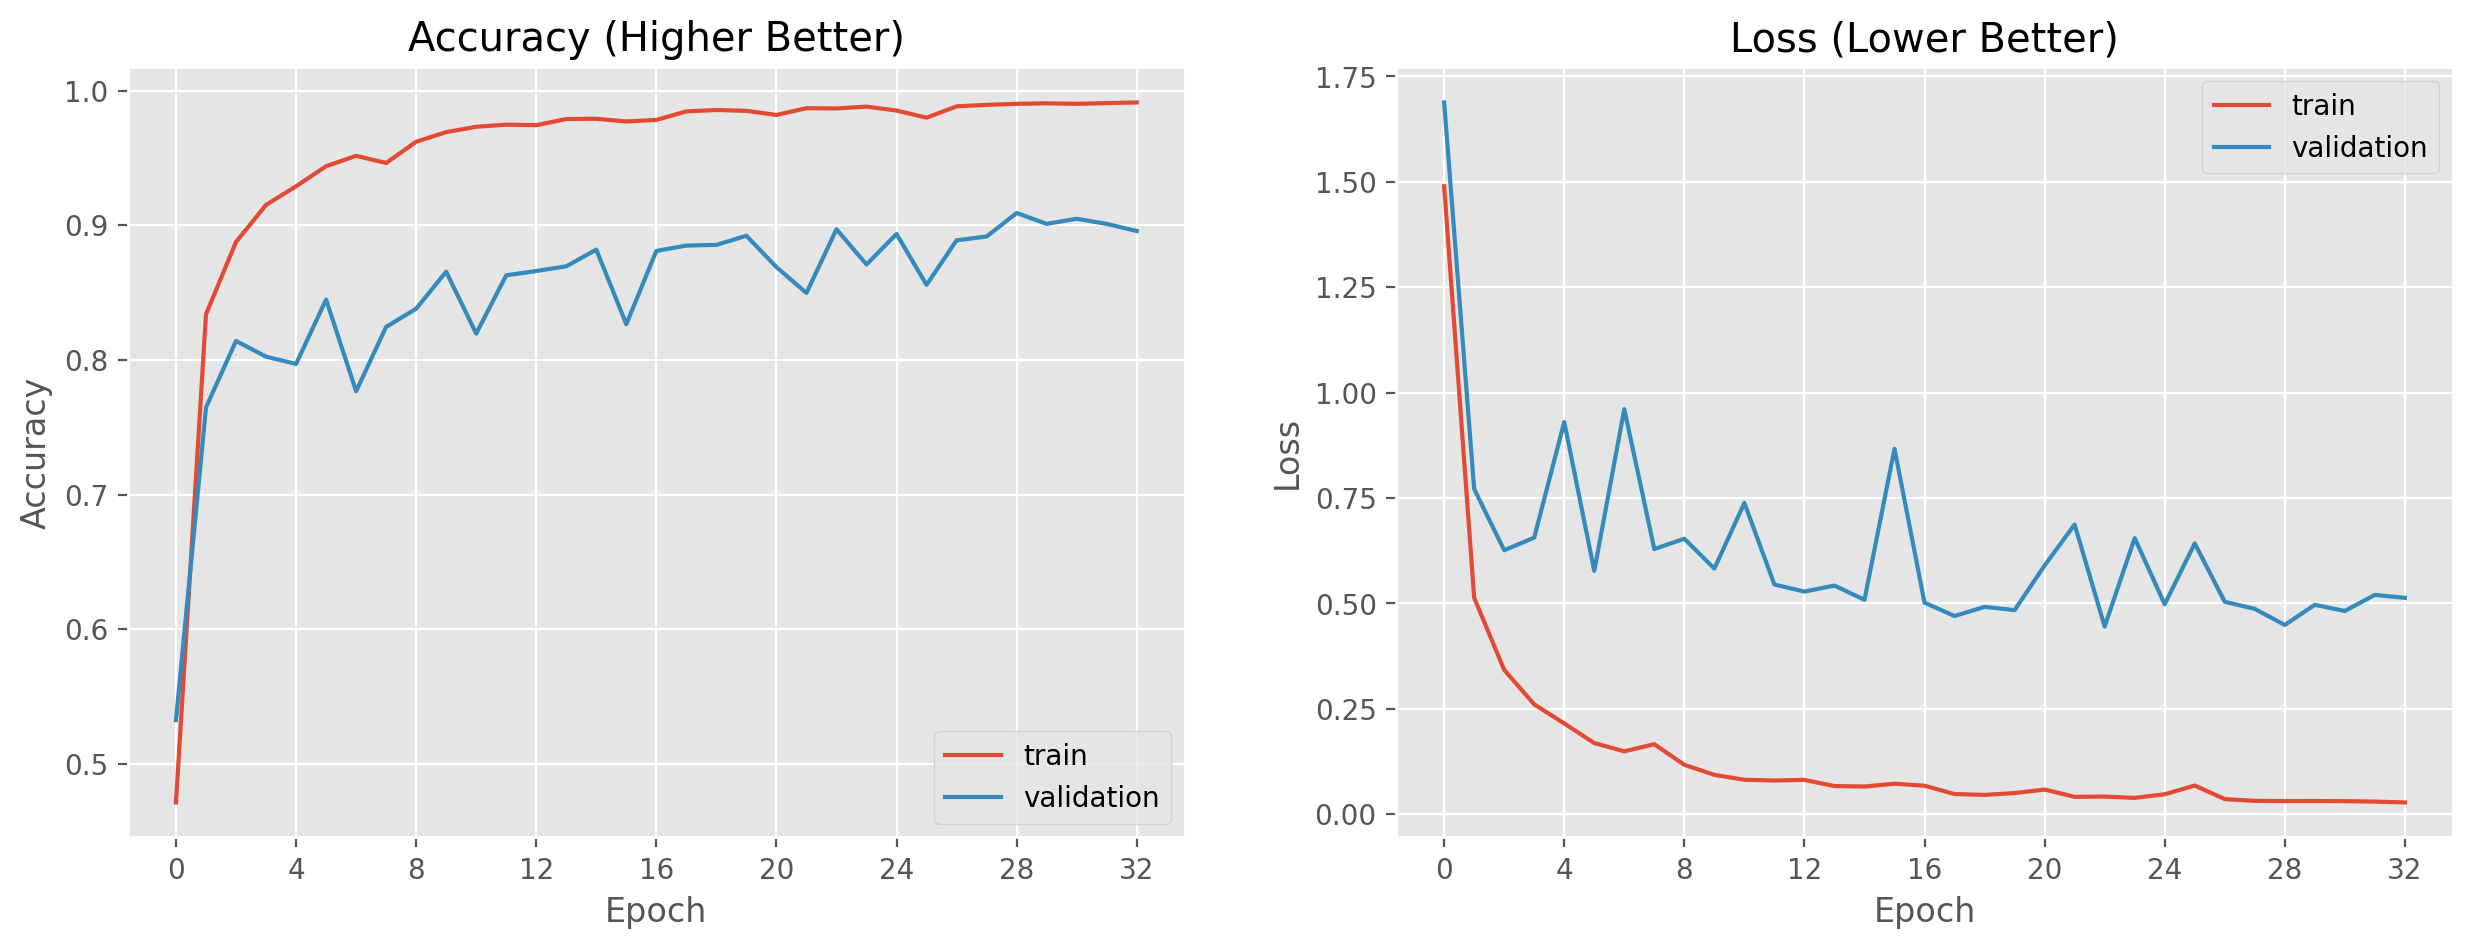

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 7s 72ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


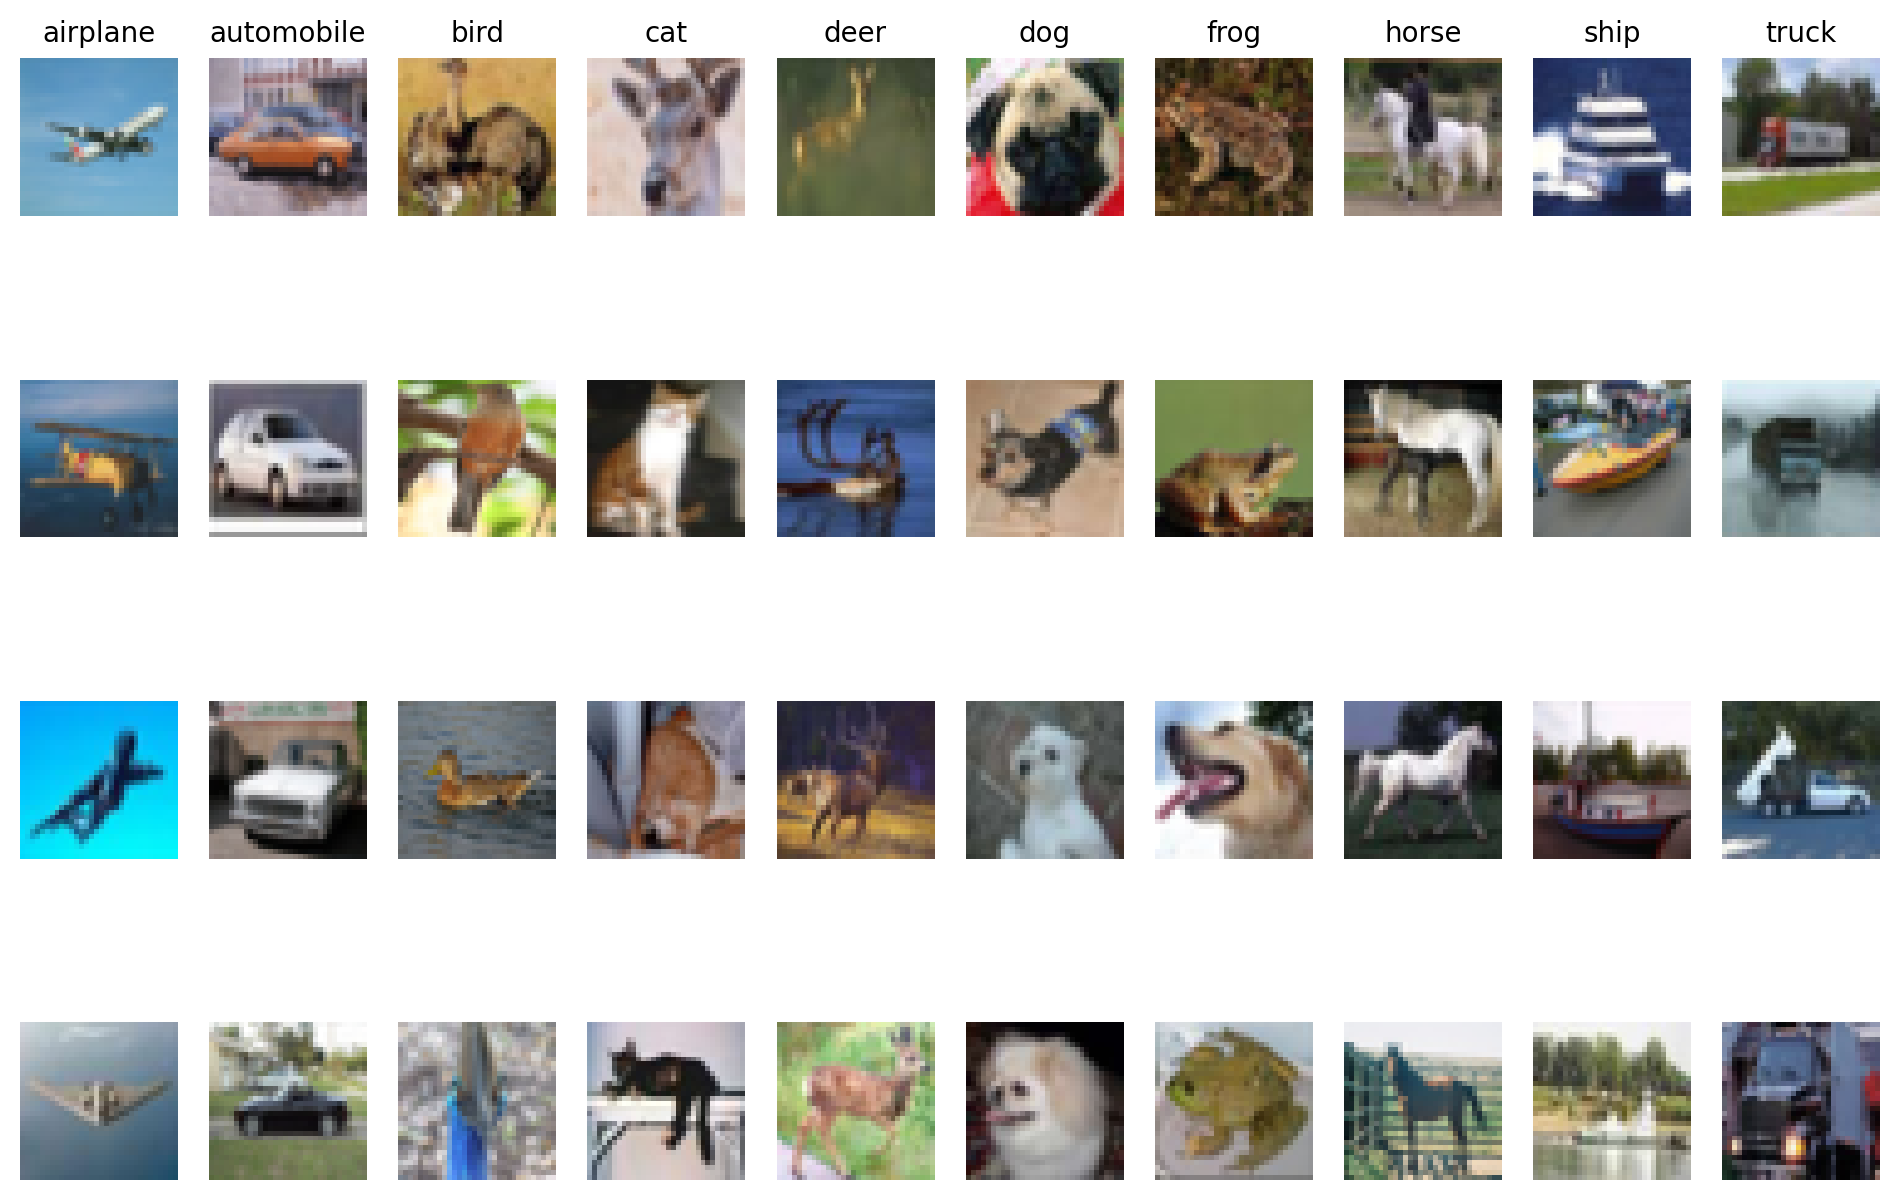

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 5 - Inception-V3

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# define batch size
batch_size = 32

# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 128
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing
- Decreased Batch size to 32
- Added layers into fully conencted layers
- Added dropouts to prevent overfitting
- Added learning Rate scheduler 

In [4]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

In [5]:
for layer in pre_model.layers:
    layer.trainable = True

In [6]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_5')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

callback = []
def decay(epoch):
    return 0.001 / (1 + 1 * 30)

callback += [keras.callbacks.LearningRateScheduler(decay)]

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Model: "InceptionV3_Tuned_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)       

2023-06-01 02:06:31.167747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-01 02:06:32.695611: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 02:06:32.696572: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 02:06:32.696634: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-01 02:06:32.697818: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 02:06:32.697931: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1563/1563 [==============================] - 265s 160ms/step - loss: 0.6533 - accuracy: 0.7999 - val_loss: 0.2091 - val_accuracy: 0.9377 - lr: 3.2258e-05
Epoch 2/50
1563/1563 [==============================] - 247s 158ms/step - loss: 0.2345 - accuracy: 0.9355 - val_loss: 0.1821 - val_accuracy: 0.9492 - lr: 3.2258e-05
Epoch 3/50
1563/1563 [==============================] - 246s 158ms/step - loss: 0.1441 - accuracy: 0.9599 - val_loss: 0.1998 - val_accuracy: 0.9482 - lr: 3.2258e-05
Epoch 4/50
1563/1563 [==============================] - 247s 158ms/step - loss: 0.1060 - accuracy: 0.9725 - val_loss: 0.1840 - val_accuracy: 0.9535 - lr: 3.2258e-05
Epoch 5/50
1563/1563 [==============================] - 246s 158ms/step - loss: 0.0818 - accuracy: 0.9785 - val_loss: 0.2166 - val_accuracy: 0.9529 - lr: 3.2258e-05
Epoch 6/50
1563/1563 [==============================] - 246s 157ms/step - loss: 0.0646 - accuracy: 0.9829 - val_loss: 0.1856 - val_accuracy: 0.9594 - lr: 3.2258e-05
Epoch 7/50
1563/1563 

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 14s 45ms/step - loss: 0.2015 - accuracy: 0.9578
Test loss:  0.20152021944522858
Test accuracy: 0.9577999711036682


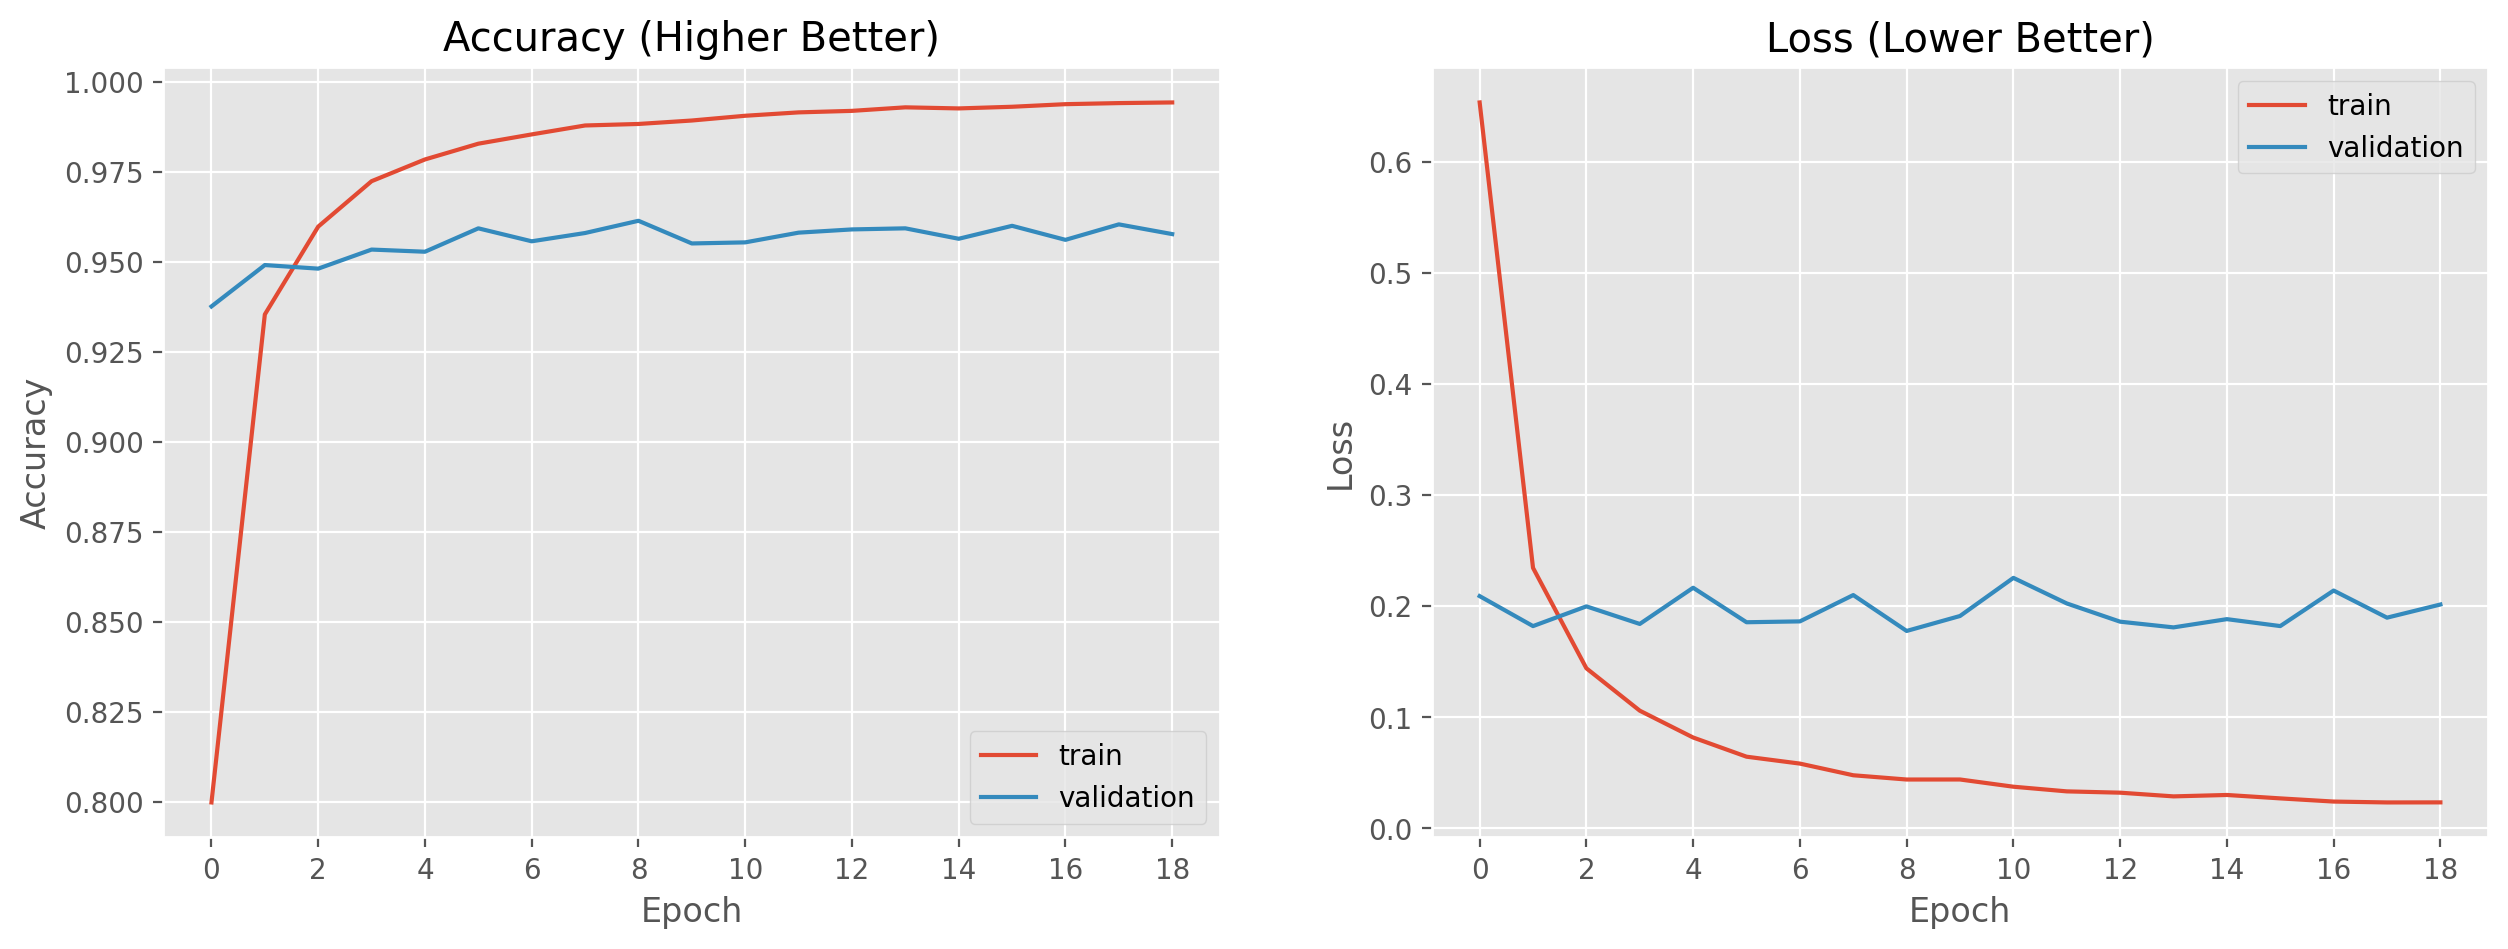

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 15s 43ms/step
[3 8 8 ... 5 1 7]


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [11]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


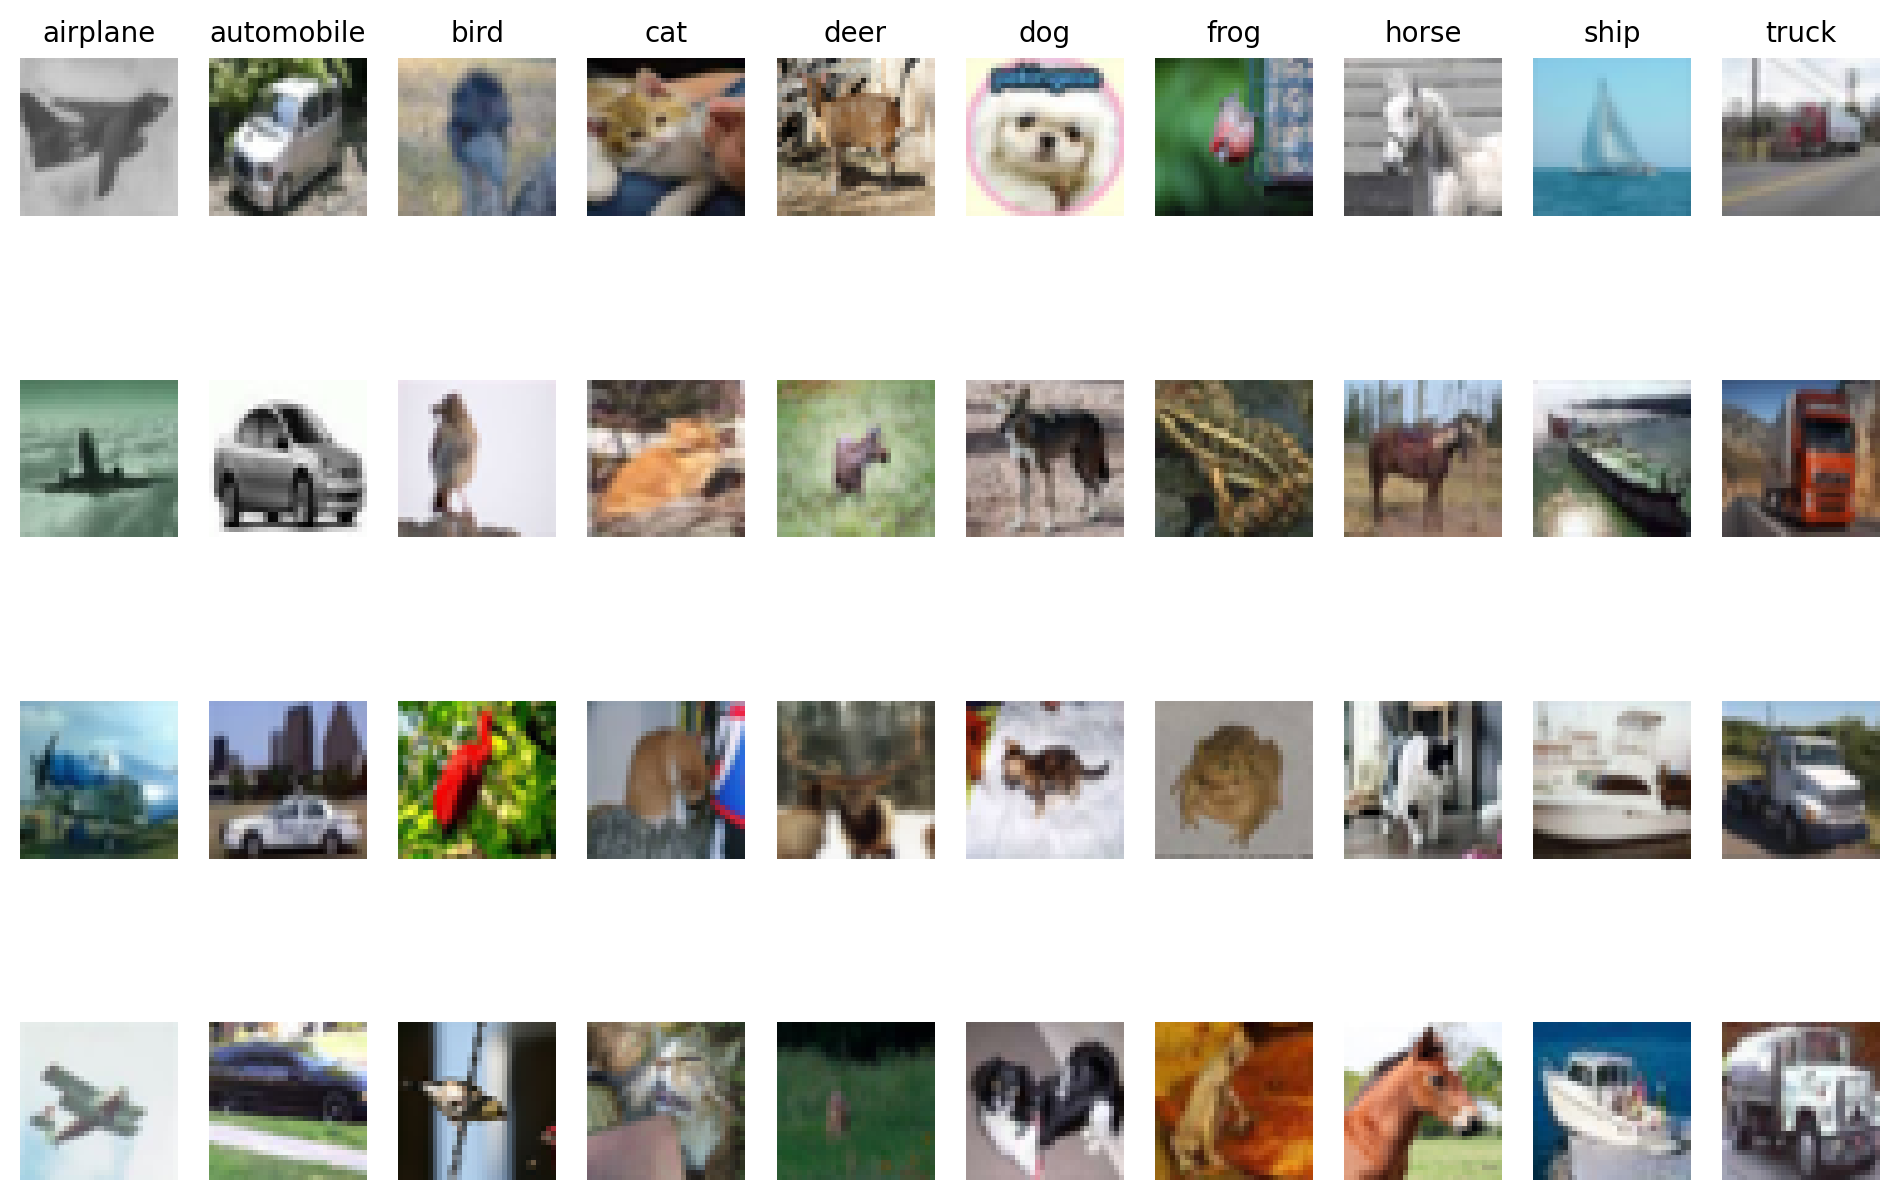

In [13]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


In [ ]:
# convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()


# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)
    




### <font color=maroon>Testing categorising on a single model

### Imports

In [17]:
import requests
from PIL import Image
from io import BytesIO

In [18]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [19]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [20]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [21]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 2s 2s/step


In [22]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [23]:
predicted_label = class_labels[predicted_class_index[0]]

In [24]:
print(predicted_label)


bird


### <font color=maroon>Visualising confusion matrix

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [27]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9578


In [28]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9585418938381332
Recall: 0.9578
F1 Score: 0.9576089896529669


### Creating confusion matrix

In [29]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

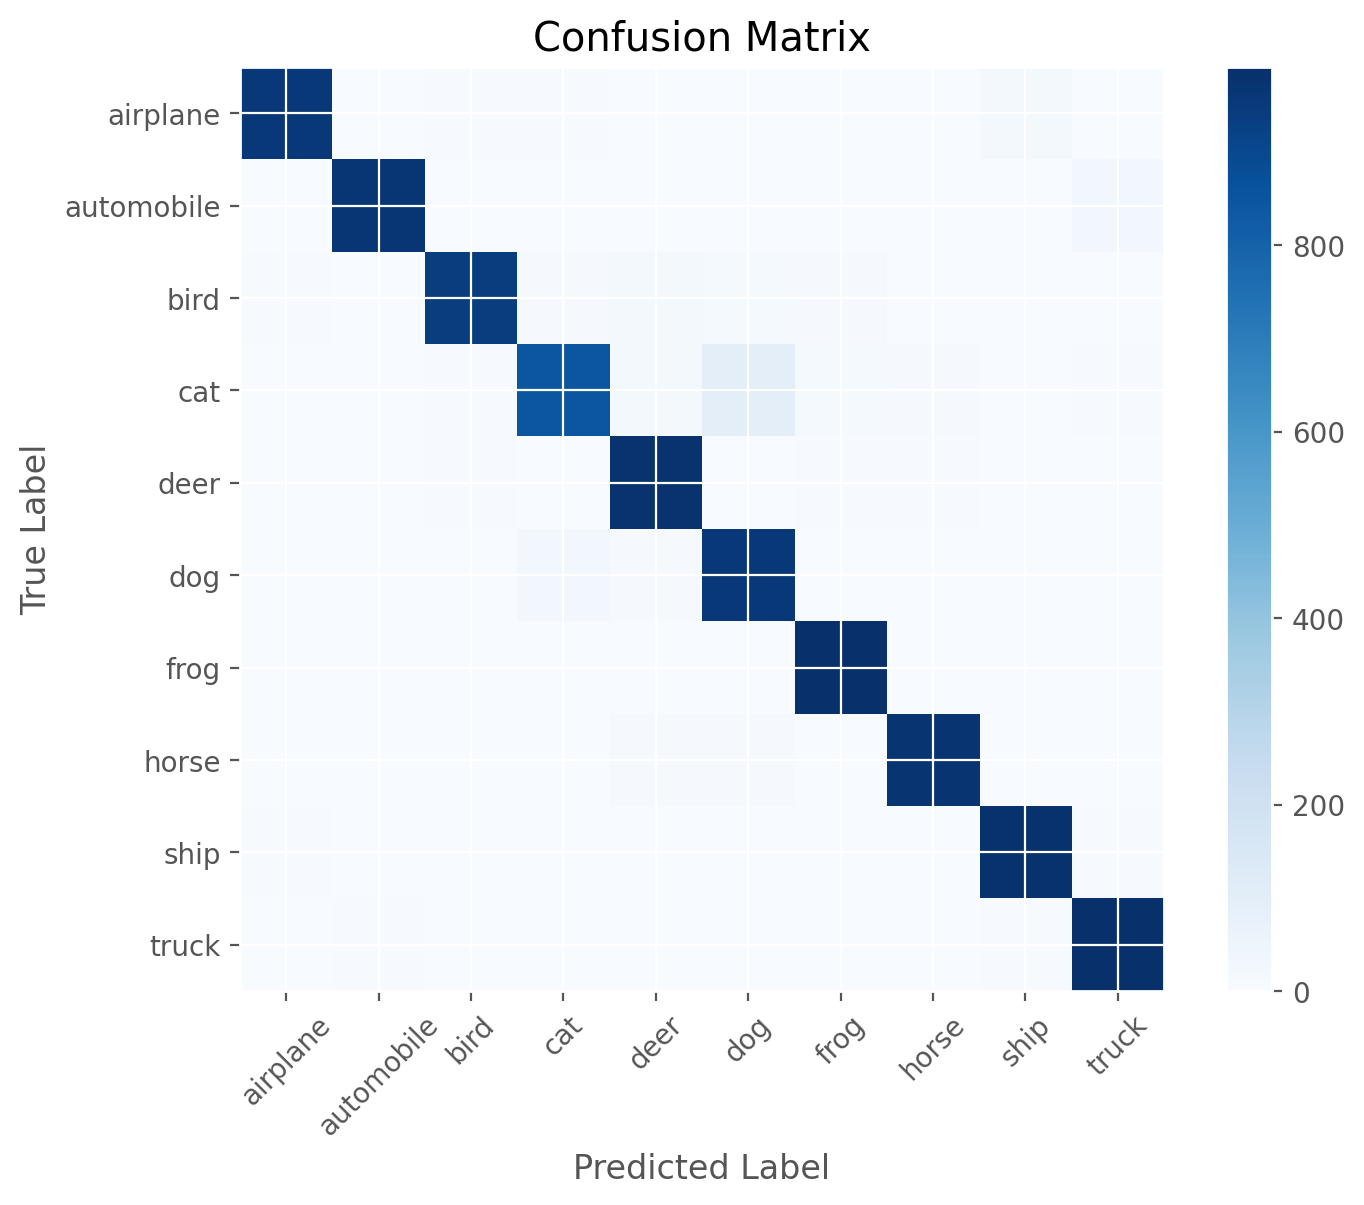

In [30]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.98      0.96      0.97      1000
  automobile       0.99      0.97      0.98      1000
        bird       0.98      0.94      0.96      1000
         cat       0.95      0.85      0.89      1000
        deer       0.94      0.98      0.96      1000
         dog       0.88      0.96      0.92      1000
        frog       0.97      0.99      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.97      0.98      0.97      1000
       truck       0.96      0.98      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

